In [2]:
.libPaths(c('/home/ssapkot/.conda/envs/r_env_360/lib', .libPaths()))

#install.packages("coda",repos='http://cran.us.r-project.org', dependencies = TRUE)
library(BGLR)
#library(doMC)
#library(foreach)
library(coda)
library(tidyverse)
library(ggplot2)
library(ggpubr)
library(qqman)
library(qqplotr)


setwd("/panicle/ssapkot/git_repo/StarchProtein")

In [8]:
df = read.table("data/SAP_Cov_all.txt", sep='\t',header=F)
head(df)
cov = df[,c(1,4)]
# head(cov)
write.table(cov,"data/SAP_TGW.txt", row.names=FALSE, col.names=FALSE)


V1,V2,V3,V4
1,-7.235870,18.34477,3.193147
1,-7.566349,88.60509,-5.884034
1,5.349072,53.18864,6.544866
1,5.288356,-30.62933,-7.709419
1,-4.744867,-33.35904,-5.226989
1,12.015334,50.29836,1.434151


chr,rs,ps,n_miss,allele1,allele0,af,beta,se,l_remle,l_mle,p_wald,p_lrt,p_score
1,S1_2482,2482,10,C,G,0.082,0.06715379,0.15266680,15.88258,1e+05,0.6602763,0.7225549,0.7227703
1,S1_14393,14393,13,T,C,0.223,-0.03158289,0.07346116,15.81057,1e+05,0.6674891,0.6817429,0.6820029
1,S1_68058,68058,15,A,G,0.056,-0.04344104,0.12492210,15.97324,1e+05,0.7282213,0.6280514,0.6283780
1,S1_245852,245852,14,C,A,0.069,0.11826070,0.15367290,15.48910,1e+05,0.4420310,0.5025325,0.5030568
1,S1_261412,261412,13,G,A,0.122,-0.01384455,0.12772040,16.12994,1e+05,0.9137369,0.8827733,0.8828520
1,S1_261458,261458,15,C,A,0.080,-0.08856005,0.15116670,15.89181,1e+05,0.5583231,0.5850877,0.5854749


[1] 27272

[1] 8.104965

chr,rs,ps,n_miss,allele1,allele0,af,beta,se,l_remle,l_mle,p_wald,p_lrt,p_score,log_p
1,S1_2482,2482,10,C,G,0.082,0.06715379,0.15266680,15.88258,1e+05,0.6602763,0.7225549,0.7227703,0.18027429
1,S1_14393,14393,13,T,C,0.223,-0.03158289,0.07346116,15.81057,1e+05,0.6674891,0.6817429,0.6820029,0.17555582
1,S1_68058,68058,15,A,G,0.056,-0.04344104,0.12492210,15.97324,1e+05,0.7282213,0.6280514,0.6283780,0.13773662
1,S1_245852,245852,14,C,A,0.069,0.11826070,0.15367290,15.48910,1e+05,0.4420310,0.5025325,0.5030568,0.35454727
1,S1_261412,261412,13,G,A,0.122,-0.01384455,0.12772040,16.12994,1e+05,0.9137369,0.8827733,0.8828520,0.03917884
1,S1_261458,261458,15,C,A,0.080,-0.08856005,0.15116670,15.89181,1e+05,0.5583231,0.5850877,0.5854749,0.25311440


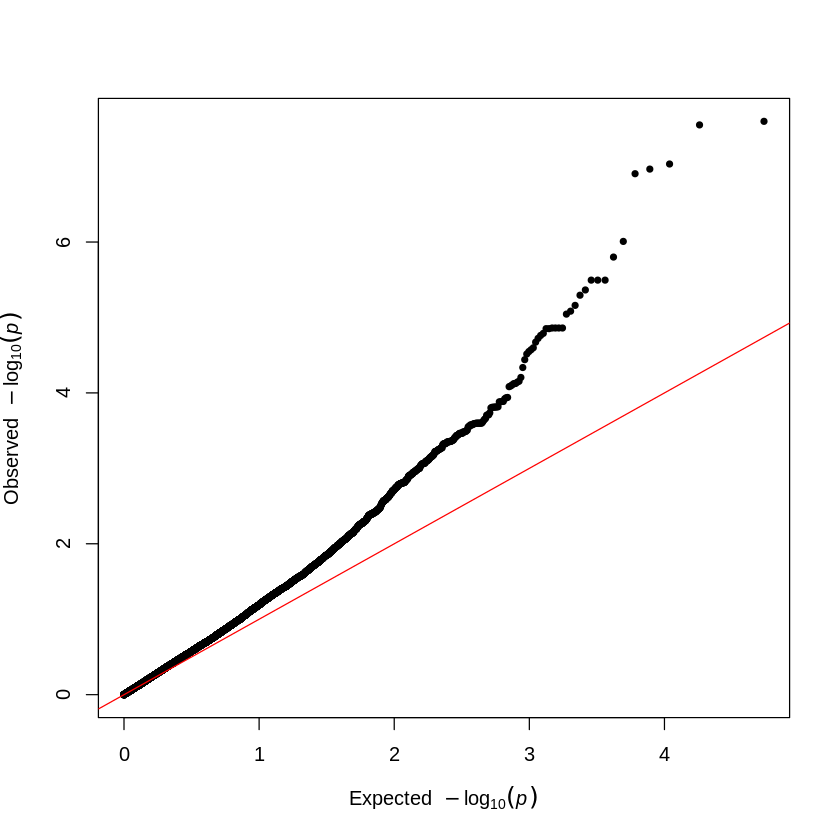

In [10]:
file = read.table('results/GWAS/output/SAP_GS/SAP_lmm_maf0.05_Starch_CovProt.assoc.txt', stringsAsFactors=FALSE, sep='\t', header=TRUE)

# observed <- sort(file$p_wald)
# lobs <- -(log10(observed))

# expected <- c(1:length(observed)) 
# lexp <- -(log10(expected / (length(expected)+1)))

# pdf("qqplot.pdf", width=6, height=6)
# plot(c(0,7), c(0,7), col="red", lwd=3, type="l", xlab="Expected (-logP)", ylab="Observed (-logP)", xlim=c(0,7), ylim=c(0,7), las=1, xaxs="i", yaxs="i", bty="l")
# points(lexp, lobs, pch=23, cex=.4, bg="black") 
# dev.off()

#png('results/QQ_StaCovPrt_maf0.05.png', width=300, height=300)
qq(file$p_lrt)
#dev.off()
#file$p.adj = p.adjust(file$p_wald, method="BH")
head(file)
#qq(file$p_wald)
file$log_p = -log10(file$p_wald)
#file\$adj.P <- p.adjust(file\$gamma, method = 'bonferroni') ##bonferroni-correction
sig <- -log10(0.05/nrow(file))
nrow(file)
#sig <- 5
sugg <- 5
max(file$log_p)

gwas.sig <- file[file$log_p > sig,]
mysnps <- gwas.sig$rs
head(file)
#write.csv(gwas.sig, '/panicle/ssapkot/GrainComp/RF/results_features/data/BSLMM/LMM_MultiVariate_SP_sigSNPs.csv', row.names=FALSE)

In [11]:
####GWAS_plotting_manhattan function
library(ggrepel)
gg.manhattan <- function(df, threshold, hlight, ylims, title){
nCHR <- length(unique(df$chr))
df$BPcum <- NA
s <- 0
nbp <- c()
for (i in unique(df$chr)){
      nbp[i] <- max(df[df$chr == i,]$ps)
        df[df$chr == i,'BPcum'] <- df[df$chr == i,'ps'] + s
          s <- s + nbp[i]
      }

###Setting up the parameters and axis
axis.set <- df %>%
  group_by(chr) %>%
    summarize(center = (max(BPcum) + min(BPcum)) / 2)

   # ylim <- abs(floor(log10(min(df\$gamma)))) + 2

    df.tmp <- df %>%
         # Add highlight and annotation information
            mutate( is_highlight=ifelse(rs %in% hlight, 'yes', 'no')) %>%
            mutate( is_annotate=ifelse(log_p > threshold, 'yes', 'no'))

  ggplot(df.tmp, aes(x=BPcum, y=log_p)) +
    geom_point(aes(color=as.factor(chr)), alpha = 0.8, size = 2) +
    ##add highlighted points
    #geom_point(data=subset(df.tmp, is_highlight=='yes'), color='darkgreen', size=2) +

    #custom axes
    scale_color_manual(values = rep(c('darkslateblue','orange'), nCHR)) +
    scale_x_continuous(label = axis.set$chr, breaks = axis.set$center) +
    scale_y_continuous(expand = c(0,0), limits = ylims) +

    # add genome-wide significant and suggested lines
    geom_hline(yintercept = sig, color = 'forestgreen', linetype = 'dashed') +
    #geom_hline(yintercept = sugg, color = 'blue', linetype = 'dashed') +

    ggtitle(paste0(title)) +
    labs(x = 'chromosome', y = '-log10(P)') +

    # Add label using ggrepel to avoid overlapping
    #geom_label_repel(data=df.tmp[df.tmp$is_annotate=='yes',], aes(label=as.factor(rs), alpha=0.7), size=5, force=1.3) +

    #customize the theme
    theme_bw(base_size=20) +
    theme(
    legend.position = 'none',
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.text.x = element_text(angle = 0,  vjust = 0.5))
    }

Warning message:
“Removed 27269 rows containing missing values (geom_point).”

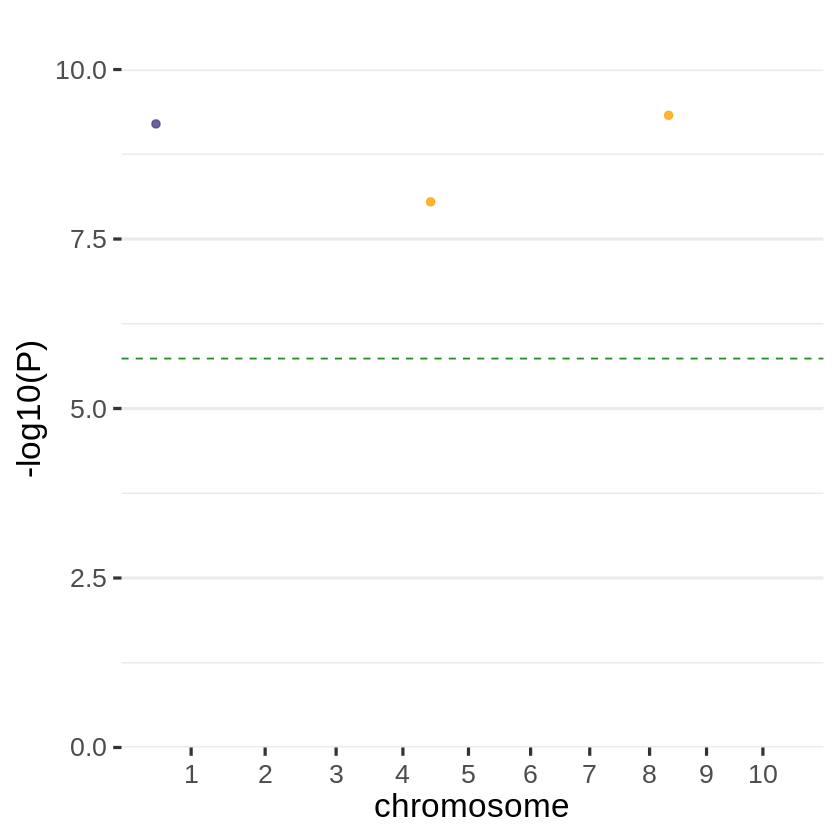

In [8]:
#png('results/GWAS/SAP_MV-SP_maf0.02_annotated.png', width=1200, height=400)
# gg.manhattan(file, sig, mysnps, c(0,10),'')
# dev.off()
 
gg.manhattan(file, sig, mysnps, c(0,10),'')